In [240]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
import time




In [241]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [242]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result





# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value


    return result





# Normalização de dados para as redes.
def zero_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
                max_value = Mat_ref[:,i].max()
                min_value = Mat_ref[:,i].min()
                result[:,i] = (Mat_dados[:,i] - min_value) / (max_value - min_value)
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] - min_value) / (max_value - min_value)

    return result
# Desnormalização de dados para as redes.
def zero_des_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:,i].max()
            min_value = Mat_ref[:,i].min()
            result[:,i] = (Mat_dados[:,i] ) * (max_value - min_value) + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] ) * (max_value - min_value) + min_value

    return result

In [422]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 rpm a 60000 rpm, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)

N_rot_example = 40412.61691244799
Mass_example = 9.62476391 
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=40412.61691244799, Mass=9.62476391: 1.49599


In [455]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4500, 5000)  # KPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(4e4, 5e4)  #Hz   # 4e4, 5e4
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [245]:
def Nale():
    return np.random.uniform(45e4, 50e3)
def P1():
    return np.random.uniform(4000, 5000)

In [628]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3        # m²
    L_c = 2.0          # m
    alpha = 0.75    #  Constante de Abertura da Valvula
    P_out = 5000       # KPa
    C1 = 479.029       # Constante
    V_p = 2.0          # m³
    K_nu = 0.38 
    0 #0.0765      # kg / (kPa^0.5 s)
    phi = interpolation([45000, x[0]]).__float__() 

    z = 0 if x[1] < P_out else np.sqrt(x[1]   - P_out)

    dmdt = (A1 / L_c) * (phi * 5000 - x[1])*1000 
    dPdt = (C1**2/V_p) * (x[0] - alpha * K_nu * sqrt(x[1] - P_out))/1000
    return [dmdt, dPdt]

stati = fsolve(Estacionario, [10, 9e3])

print(stati,Estacionario(stati))

[  13.40272212 7211.54768046] [np.float64(-4.8814217734616246e-08), np.float64(-1.0347394145815488e-09)]


In [630]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0]))
    
    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.75        # Constante Abertura da valvula
    P_out = 5000         #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38          # kg / (kPa^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))
    non = if_else(phi<0,phi+1,phi)
    
    rhs = vertcat(
        (A1 / L_c) * ( non* p[0] - x[1] )*1000,                                     # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha* K_nu * sqrt(x[1] - P_out))/1000                             # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    
    F = integrator('F', 'cvodes', ode)

    #
    t_eval = np.linspace(0, 60,600)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9
    sol[0,:] = x0
    #
    print(P1_value, N_value)
    for i in range(len(t_eval)-1):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i+1] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval
    


In [248]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []
    for i in range(loops):
        if i == 0:
            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]
        print(x0)
        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation, N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

[  13.40272212 7211.54768046]
4595.379262007775 46148.541180915854
Tempo de execução: 0.09122085571289062 segundos
[  13.08468501 7107.83603387]
4677.601666308539 46232.878148482436
Tempo de execução: 0.07094883918762207 segundos
[  13.27576214 7169.84746692]
4888.863059565639 41600.255532080686
Tempo de execução: 0.06466794013977051 segundos
[  12.05240269 6788.37070544]
4590.193020042083 45348.97012598399
Tempo de execução: 0.07446432113647461 segundos
[  12.78492029 7012.36302739]
4975.039366069427 48266.859028686245
Tempo de execução: 0.06709742546081543 segundos
[  14.50657841 7590.83800829]
4821.164870780924 45627.91849070581
Tempo de execução: 0.07460165023803711 segundos
[  13.32219413 7185.05209425]
4745.787531900528 45398.472931462224
Tempo de execução: 0.0660707950592041 segundos
[  13.1055876  7114.57588724]
4917.423549997121 49070.66511257936
Tempo de execução: 0.06631112098693848 segundos
[  14.70203117 7661.12305804]
4937.7205596911635 45834.20998680423
Tempo de execução

C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\4187517312.py:13: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\4187517312.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



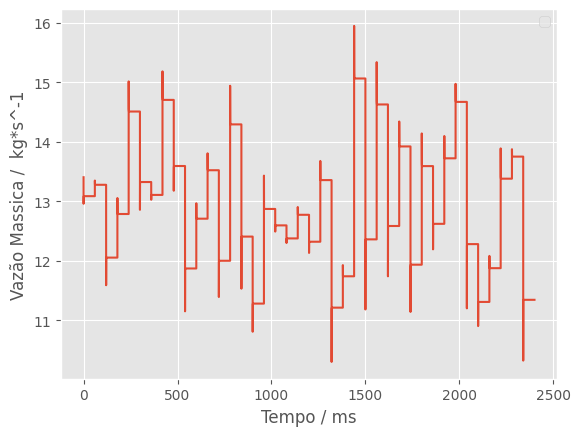

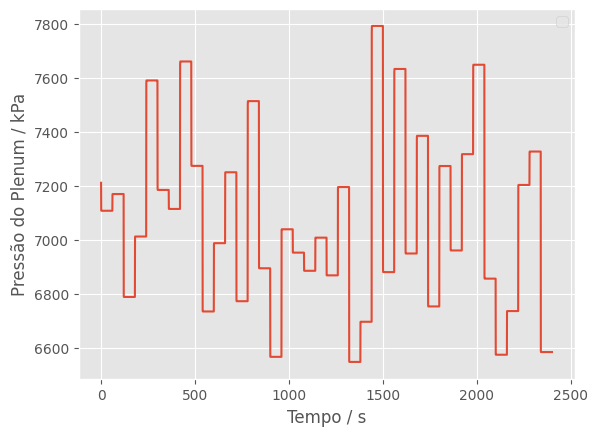

In [662]:

aaaa, PlotP1, PlotN, Plott = Loop(40, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados
plt.figure()
plt.plot(Plott,Ploty[:, 0])
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.legend()
plt.grid(True)
plt.figure()
plt.plot(Plott,Ploty[:, 1])
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()


In [663]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:] #X_train, X_test = X[120:split_index+split_index//2], X[split_index//2+split_index:]        
y_train, y_test = y[:split_index], y[split_index:] #y_train, y_test = y[120:split_index+split_index//2], y[split_index//2+split_index:]        

In [664]:
print(split_index)
X_train.shape
y_train.shape

11999


(11999, 2)

In [665]:
X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [593]:
print(des_normalize(y_test_ref,y_test_tensor))

[[  12.07927036 6796.35302734]
 [  12.51805496 6842.18847656]
 [  12.46238041 6866.37548828]
 ...
 [  12.08652306 6798.51074219]
 [  12.08652306 6798.51074219]
 [  12.08652306 6798.51074219]]


C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2731176872.py:28: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



In [262]:
print(y_test)

[[0.11284217 0.15328049]
 [0.11284217 0.15328049]
 [0.21151614 0.19606164]
 ...
 [0.27676656 0.38497204]
 [0.27676656 0.38497204]
 [0.27676656 0.38497204]]


In [666]:

# Modelo em PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.Tanh()
        self.fc = nn.Linear(hidden_dim ,output_dim )  # 2*hidden_dim por ser bidirecional
        self.fc1 = nn.Linear(hidden_dim, output_dim)  # 2*hidden_dim por ser bidirecional

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) )  # Concatenar saídas bidirecionais

        x = self.dropout(h_n)
        x = self.activation(self.fc(x))
        #x = self.fc1(x)

        return x

In [ ]:
y_test_tensor.shape[0]


5761

In [595]:
# Definir parâmetros do modelo
input_dim = X_train_tensor.shape[2]
output_dim = y_train_tensor.shape[1]

# Treinamento do modelo
n_epochs = 70
batch_size = 32 # 64   
early_stop_patience = 180

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)




In [596]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    hidden_dim = trial.suggest_int("hidden_dim", 10, 60)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad
            ()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return loss.item()

In [673]:

# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize') #sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize 

[I 2024-12-08 03:24:32,552] A new study created in memory with name: no-name-fffed70d-c7b2-4bee-a495-817ba9ec1654


<bound method Study.optimize of <optuna.study.study.Study object at 0x00000206C23C8590>>

In [ ]:
study.optimize(objective, n_trials=10)
print(study.best_params
      )

[I 2024-12-08 03:26:14,540] Trial 0 finished with value: 0.05037451535463333 and parameters: {'dropout_rate': 0.11011134427587006, 'hidden_dim': 29, 'learning_rate': 1.1695042192097185e-05}. Best is trial 0 with value: 0.05037451535463333.
[I 2024-12-08 03:27:54,229] Trial 1 finished with value: 0.019036471843719482 and parameters: {'dropout_rate': 0.13218388270360246, 'hidden_dim': 60, 'learning_rate': 1.3729483790581088e-05}. Best is trial 1 with value: 0.019036471843719482.
[I 2024-12-08 03:29:25,360] Trial 2 finished with value: 0.08745112270116806 and parameters: {'dropout_rate': 0.23262257319952345, 'hidden_dim': 20, 'learning_rate': 1.0441652588857856e-05}. Best is trial 1 with value: 0.019036471843719482.
[I 2024-12-08 03:30:56,805] Trial 3 finished with value: 0.023995399475097656 and parameters: {'dropout_rate': 0.1804461392878122, 'hidden_dim': 23, 'learning_rate': 2.0095778940197666e-05}. Best is trial 1 with value: 0.019036471843719482.
[I 2024-12-08 03:32:31,281] Trial 4 

C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2082062757.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.

C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2082062757.py:3: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

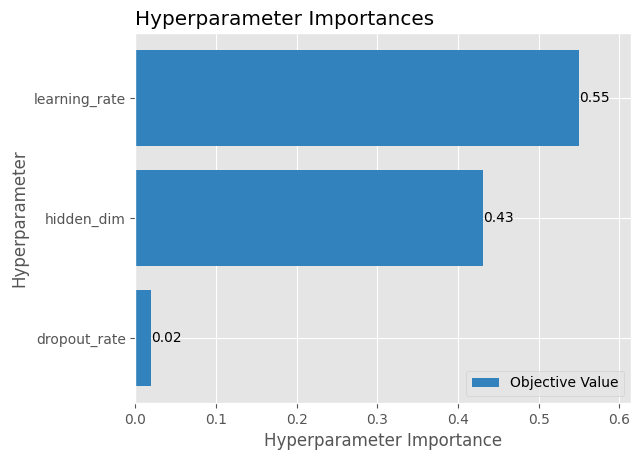

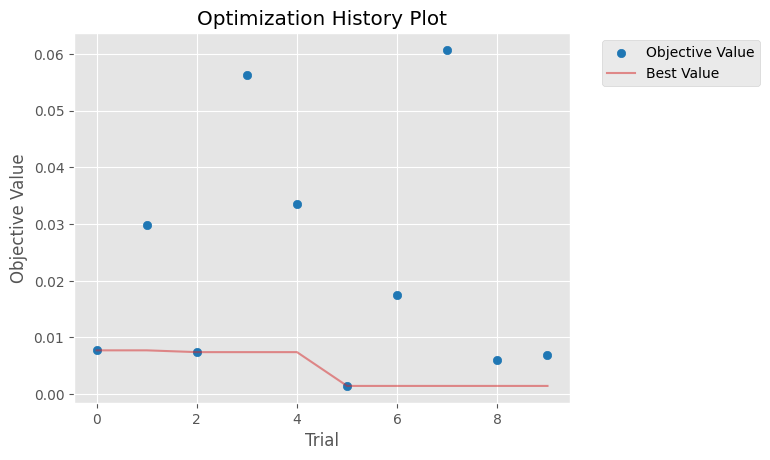

In [ ]:
from plotly.io import show
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_optimization_history(study)

In [668]:
best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim = best_params['hidden_dim'] 
dropout_rate =  best_params['dropout_rate'] 
learning_rate =best_params['learning_rate']

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(best_params)


# Para armazenar as perdas de treino e validação
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 100


for epoch in range(1000):
    model.train
    batch_train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
    
    # Perda média do treino na época atual
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    
    model.eval()
    with torch.no_grad():
        batch_val_losses = [criterion(model(X_val), y_val).item() for X_val, y_val in test_loader]
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        #if patience >= early_stop_patience:
            #print("Early stopping")
            #break

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Carregar o melhor modelo salvo
model.load_state_dict(best_model)



{'dropout_rate': 0.26988994639214847, 'hidden_dim': 18, 'learning_rate': 3.586636626510806e-05}
Epoch 1/70, Train Loss: 0.30967091801058916, Val Loss: 0.24215110349986288


KeyboardInterrupt: 

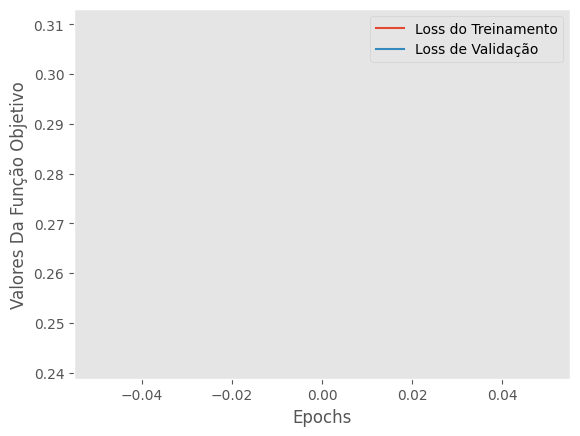

In [669]:
#{'dropout_rate': 0.12203289501741924, 'hidden_dim': 56, 'learning_rate': 4.67573896148755e-05}
plt.plot(train_losses, label='Loss do Treinamento')
plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Valores Da Função Objetivo')
plt.grid()
plt.show()

In [670]:
# Carregar o melhor modelo salvo

model.load_state_dict(best_model)
tempos = []
# Avaliação final com o conjunto de teste
model.eval()
mse = nn.MSELoss()


Tempo de execução: 0.010037899017333984 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2731176872.py:28: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



<Figure size 3000x100 with 0 Axes>

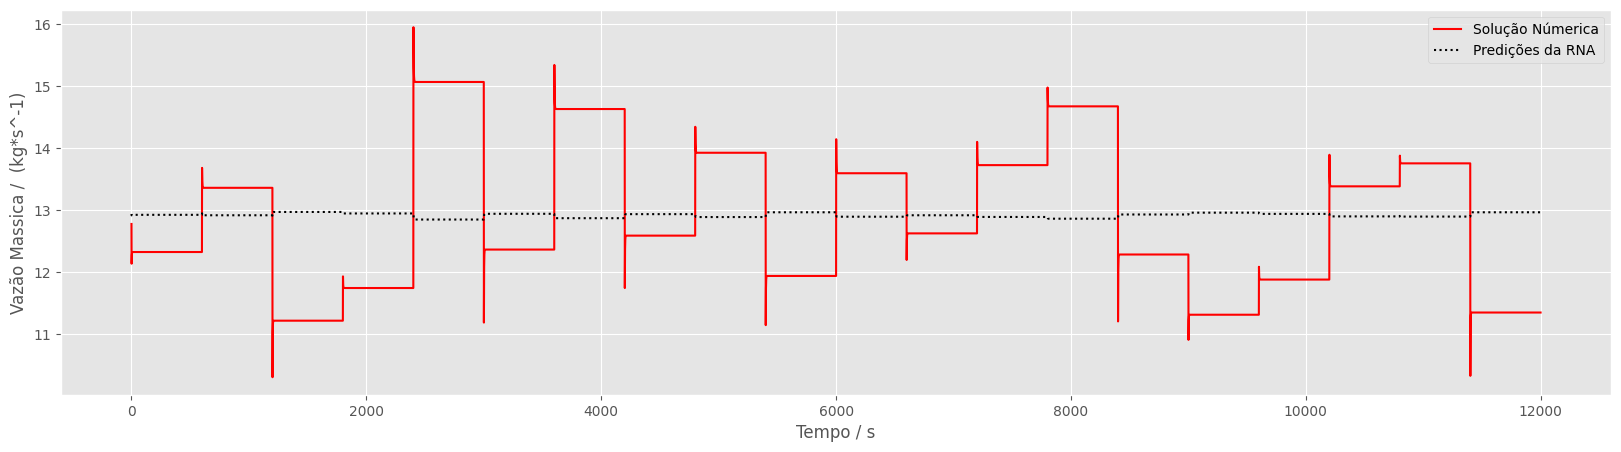

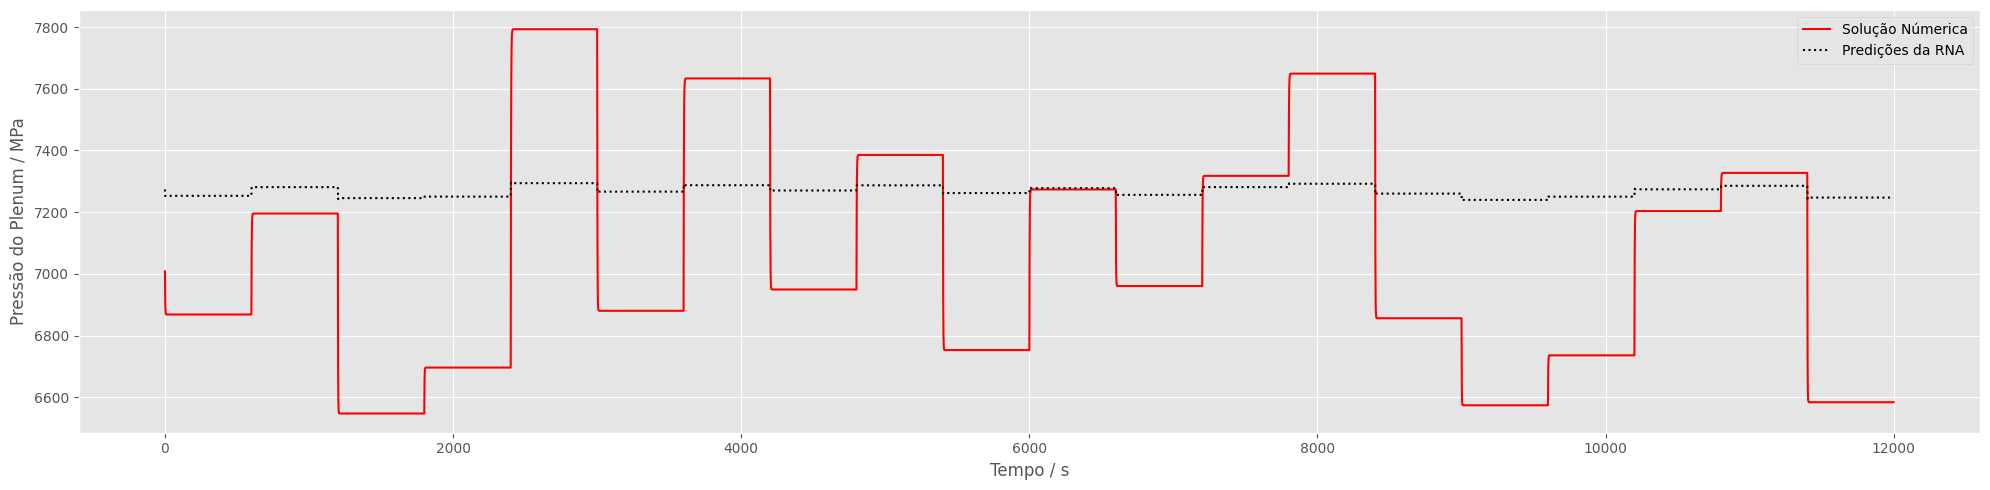

In [672]:
tempo =np.linspace(0,len(y_test),5760//2)

with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original = des_normalize(y_test_ref, y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Vazão Massica /  (kg*s^-1)')
#plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 1], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 1], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / MPa')
#lt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico

plt.tight_layout()
plt.show()

In [604]:
torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\0812.pth")

In [605]:
model_load = torch.load(r"C:\Users\fabio\PycharmProjects\PRH-1\model\0812.pth")

C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\1254195352.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Tempo de execução: 0.00907135009765625 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2731176872.py:28: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



<Figure size 3000x100 with 0 Axes>

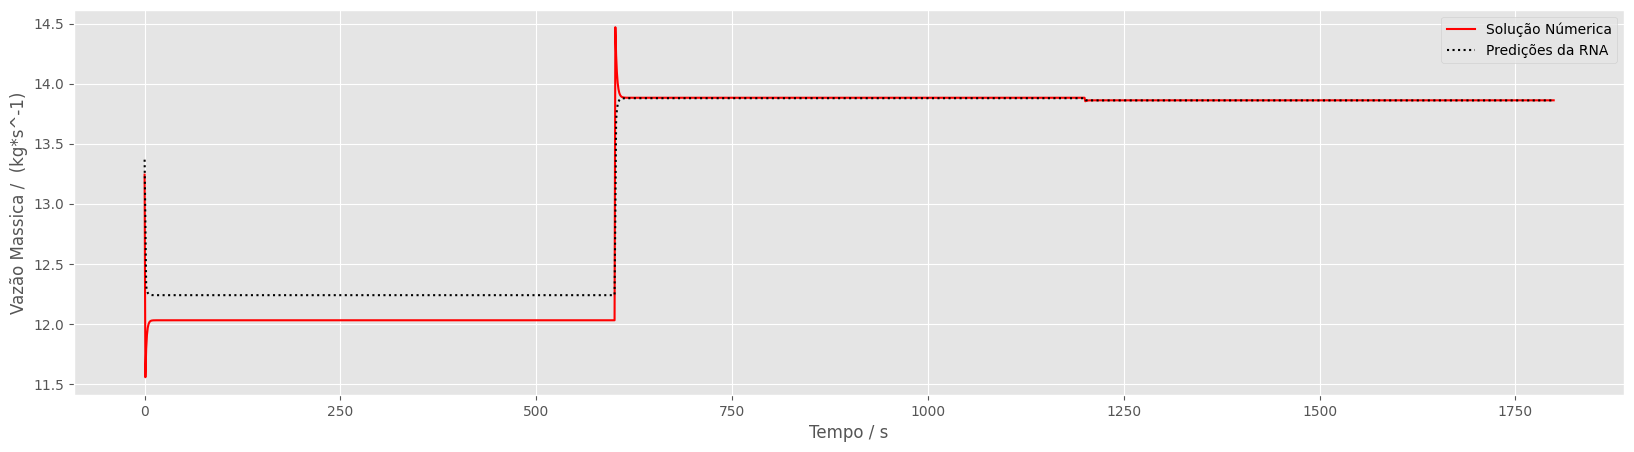

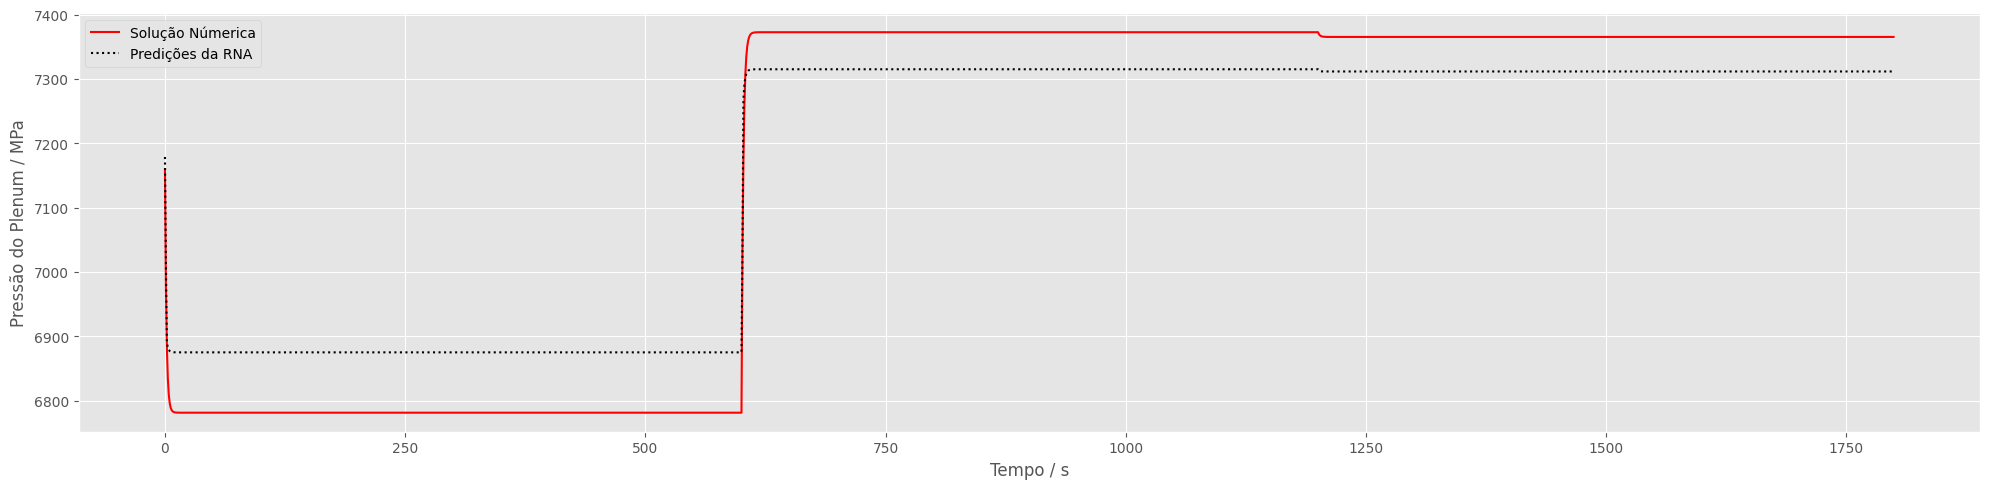

In [636]:
tempo =np.linspace(0,len(y_test),5760//2)

with torch.no_grad():
    start = time.time()
    y_test_pred = model_load(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original = des_normalize(y_test_ref, y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Vazão Massica /  (kg*s^-1)')
#plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 5))
plt.plot(y_test_original[:, 1], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 1], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / MPa')
#lt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico

plt.tight_layout()
plt.show()

In [ ]:

with torch.no_grad():

    for i in range (10000):
        start = time.time()
        y_test_pred = model(X_test_tensor)
        end = time.time()
        print(f"Tempo de execução: {end - start} segundos")
        test_loss = criterion(y_test_pred, y_test_tensor)
        tempo = end - start
        tempos.append(tempo)
        #print(f"Teste Loss: {test_loss.item()}")


In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

Tempo de execução: 0.023981571197509766 segundos


C:\Users\fabio\AppData\Local\Temp\ipykernel_33180\2731176872.py:28: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.



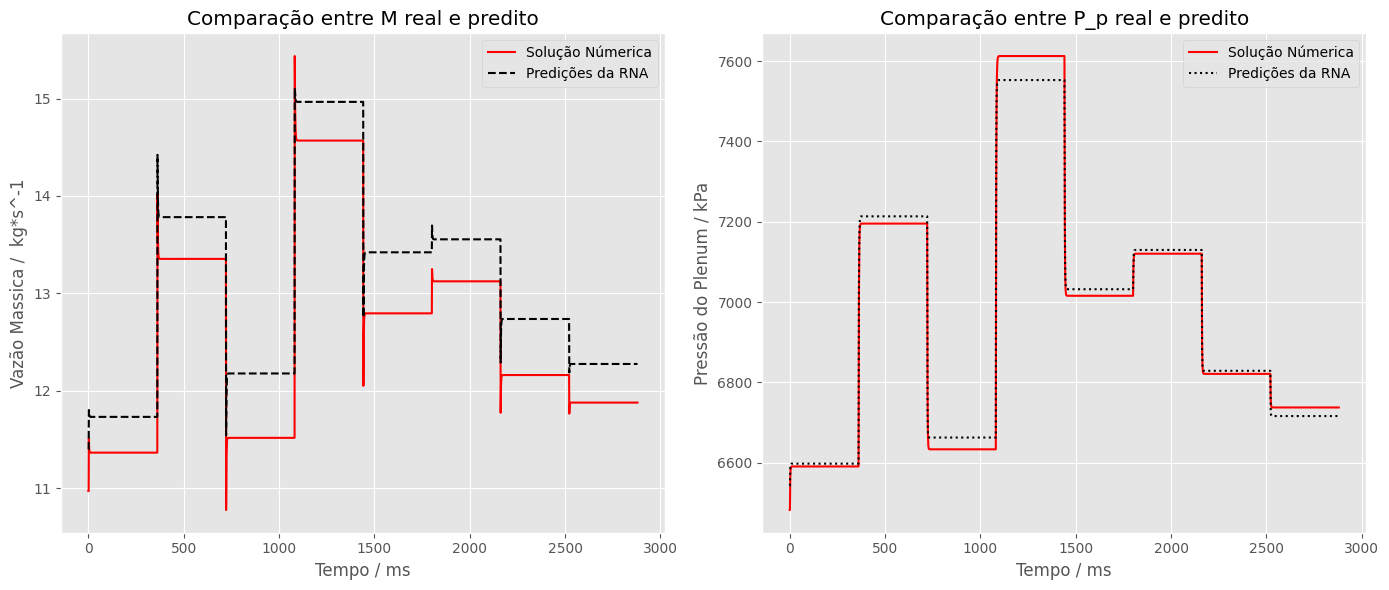

In [520]:
mse = nn.MSELoss()
with torch.no_grad():
    start = time.time()
    y_test_pred = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = mse(y_test_pred, y_test_tensor)


y_test_pred_original =  des_normalize(y_test_ref,y_test_pred)
y_test_original = des_normalize(y_test_ref,y_test)



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label="Solução Númerica" ,color="red")
plt.plot(y_test_pred_original[:, 1], ":", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


In [ ]:
#torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\model22222222.pth")

In [ ]:
model_load1 = torch.load(r"C:\Users\fabio\PycharmProjects\PRH-1\model\model1111111111.pth")




C:\Users\fabio\AppData\Local\Temp\ipykernel_29652\2437977347.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

